## Background

In this notebook I'll walk through an algorithm suggested by Claude to distinguish one typeface (like `display`) from another (like `serif`) in which we calculate two ratios:

- the ratio of the mean of 2D FFT magnitude to the count of non-zero binarized pixels ("FFT Magnitude Ratio")
- the ratio of the sum of the absolute value of 2D FFT phase to the sum of binarized pixels ("FFT Phase Ratio")

This algorithm is part of my exploration of non-ML baselines to classify text images into various typeface categories (e.g., “humanist sans,” “grotesque sans,” “script,” “display,” etc.). Once the non-ML baseline is established, I'll train a neural network for this task. This is one of many notebooks in my [TypefaceClassifier project series](https://vishalbakshi.github.io/blog/#category=TypefaceClassifier).

I'm not very familiar with Fourier transforms (especially for images), so I did a bit of review by watching the following two YouTube videos:

- [Introduction to Image Processing with 2D Fourier Transform](https://www.youtube.com/watch?v=tlwIWjeuu8U)
- [2D Fourier Transform Explained with Examples](https://www.youtube.com/watch?v=3gAZ0U66AEA&t=0s)

A couple of key takeaways from those videos that apply to this algorithm:


- A 2D Fourier transform is centered at the center of the plot (i.e. 0-frequency is at the center of the image, so, for a 512x512px image the 0-frequency would be at (256, 256))
- The frequency increases as you radiate away from the center of the plot to the edges.
- The phase, and not just the amplitude, is very important for capturing information about a 2D image.

I'll try to illustrate these key points as I walk through the algorithm.

In [1]:
#| code-fold: true
#| code-summary: "Show imports"
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from google.colab.patches import cv2_imshow

## Load and Binarize the Image

We start, as we usually do, by loading and binarizing the image.

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
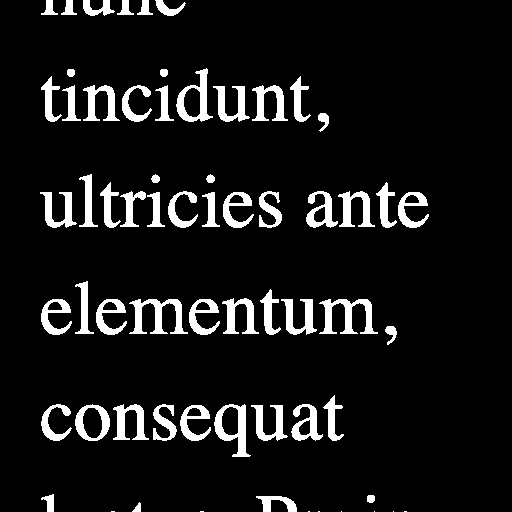

In [134]:
path = 'serif-76px.png'
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
binary

## Calculating the 2D Fast Fourier Transform

Using NumPy, I calculate the 2D FFT:

In [135]:
f = np.fft.fft2(binary)

In [136]:
f.shape

(512, 512)

I'll use a Claude-generated helper function to plot this in 3D:

In [85]:
#| code-fold: true
#| code-summary: "Show `plot_fft2_3d` function"
def plot_fft2_3d(image_path):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Compute the 2D Fourier Transform
    f = np.fft.fft2(img)

    # Shift the zero-frequency component to the center of the spectrum
    f_shift = np.fft.fftshift(f)

    # Compute the magnitude spectrum
    magnitude_spectrum = np.log(np.abs(f_shift) + 1)  # Adding 1 to avoid log(0)

    # Compute the phase spectrum
    phase_spectrum = np.angle(f_shift)

    # Calculate and print the min and max values of the phase spectrum
    phase_min = np.min(phase_spectrum)
    phase_max = np.max(phase_spectrum)
    print(f"Minimum phase value: {phase_min:.4f}")
    print(f"Maximum phase value: {phase_max:.4f}")

    # Create a grid for the 3D plots
    rows, cols = magnitude_spectrum.shape
    x = np.linspace(0, cols, cols)
    y = np.linspace(0, rows, rows)
    x, y = np.meshgrid(x, y)

    # Create the 3D plots
    fig = plt.figure(figsize=(10,8))

    # Magnitude spectrum subplot
    ax1 = fig.add_subplot(121, projection='3d')
    surf1 = ax1.plot_surface(x, y, magnitude_spectrum, cmap='viridis')
    ax1.set_xlabel('Frequency (x)')
    ax1.set_ylabel('Frequency (y)')
    ax1.set_zlabel('Magnitude (log scale)')
    ax1.set_title('Magnitude Spectrum')
    fig.colorbar(surf1, shrink=0.5, aspect=20, ax=ax1, pad=0.1)

    # Phase spectrum subplot
    ax2 = fig.add_subplot(122, projection='3d')
    surf2 = ax2.plot_surface(x, y, phase_spectrum, cmap='hsv')
    ax2.set_xlabel('Frequency (x)')
    ax2.set_ylabel('Frequency (y)')
    ax2.set_zlabel('Phase (radians)')
    ax2.set_title('Phase Spectrum')
    fig.colorbar(surf2, shrink=0.5, aspect=20, ax=ax2, pad=0.1)

    plt.suptitle('3D Plots of 2D Fourier Transform', fontsize=16)
    plt.tight_layout()
    plt.show()

A few things to point out (other than it looks cool, which it does):

- The very lowest frequencies have the highest magnitudes.
- The magnitude plot is symmetrical in both axes (which is usual for images).
- The phase values oscillate between negative and positive $\pi$ radians.

Minimum phase value: -3.1415
Maximum phase value: 3.1416


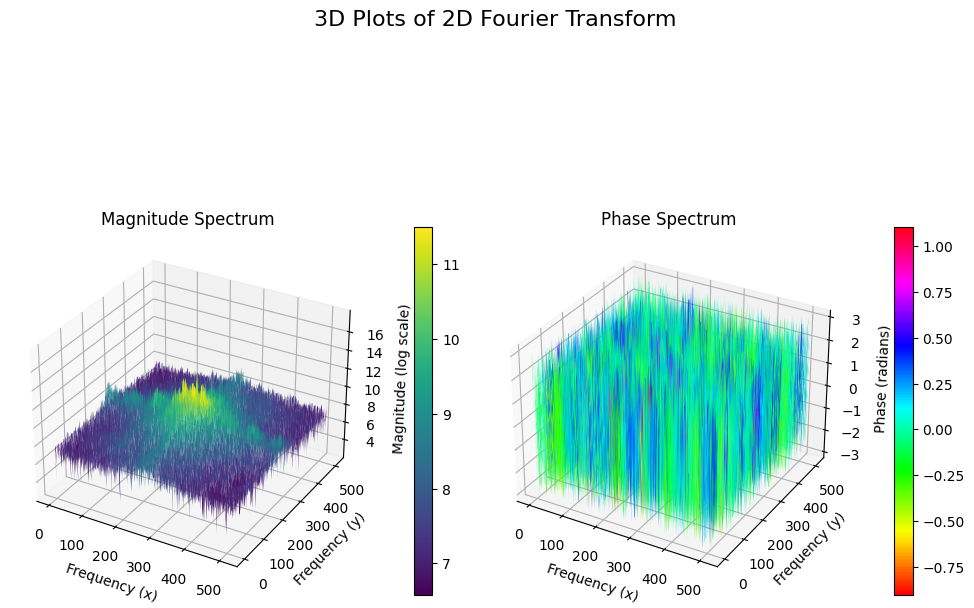

In [86]:
plot_fft2_3d('serif-76px.png')

Next, to illustrate the difference between high and low frequencies and the magnitude and phase in the frequency domain, I'll use another Claude-generated helper function to plot the _inverse_ 2D FFT of the following four things:

- high frequencies, magnitude only
- low frequencies, magnitude only
- high frequencies, phase only
- low frequencies, phase only

In [95]:
#| code-fold: true
#| code-summary: "Show `visualize_inverse_fft` function"
def visualize_inverse_fft(image_path):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply threshold
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Compute the 2D Fourier Transform
    f = np.fft.fft2(binary)

    # Shift the zero-frequency component to the center of the spectrum
    f_shift = np.fft.fftshift(f)

    # Get the magnitude and phase spectrums
    magnitude_spectrum = np.abs(f_shift)
    phase_spectrum = np.angle(f_shift)

    # Create a high-pass filter
    rows, cols = binary.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 0

    # Apply high-pass and low-pass filters
    f_high = f_shift * mask
    f_low = f_shift * (1 - mask)

    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    fig.suptitle('Inverse FFT Visualizations', fontsize=16)

    # Function to perform inverse FFT and display result
    def plot_ifft(ax, f, title):
        f_ishift = np.fft.ifftshift(f)
        img_back = np.fft.ifft2(f_ishift)
        img_back = np.abs(img_back)
        ax.imshow(img_back, cmap='gray')
        ax.set_title(title)
        ax.axis('off')

    # High frequencies, magnitude only
    plot_ifft(axs[0, 0], np.abs(f_high), 'High Freq, Magnitude Only')

    # Low frequencies, magnitude only
    plot_ifft(axs[0, 1], np.abs(f_low), 'Low Freq, Magnitude Only')

    # High frequencies, phase only
    plot_ifft(axs[1, 0], np.exp(1j * np.angle(f_high)), 'High Freq, Phase Only')

    # Low frequencies, phase only
    plot_ifft(axs[1, 1], np.exp(1j * np.angle(f_low)), 'Low Freq, Phase Only')

    plt.tight_layout()
    plt.show()

As you can see below (bottom left of both groups of plots---`serif-76px.png` and `display-76px.png`) most of the information of the letter contours is captured by the high frequency phase of the 2D FFT.

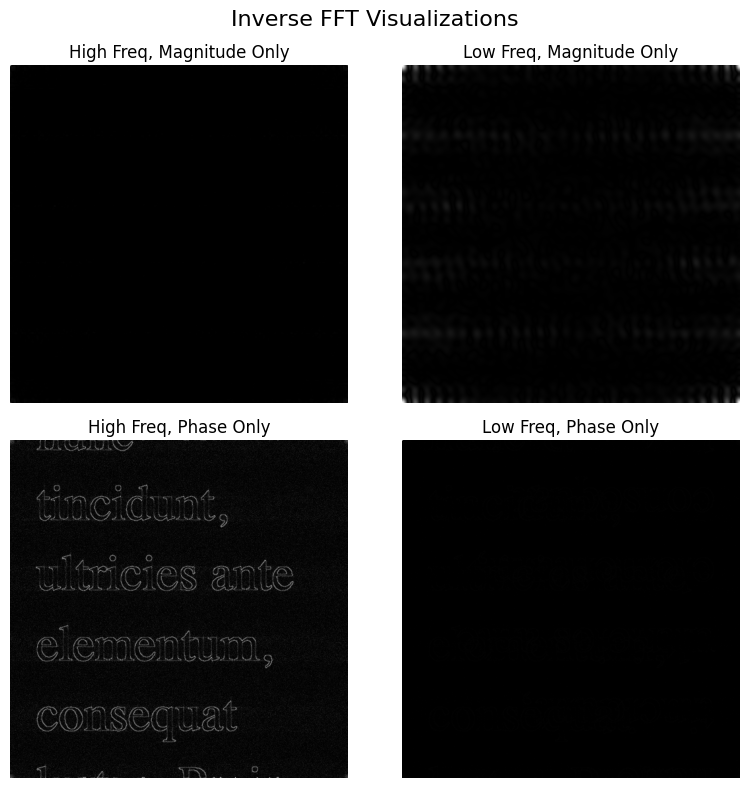

In [96]:
visualize_inverse_fft('serif-76px.png')

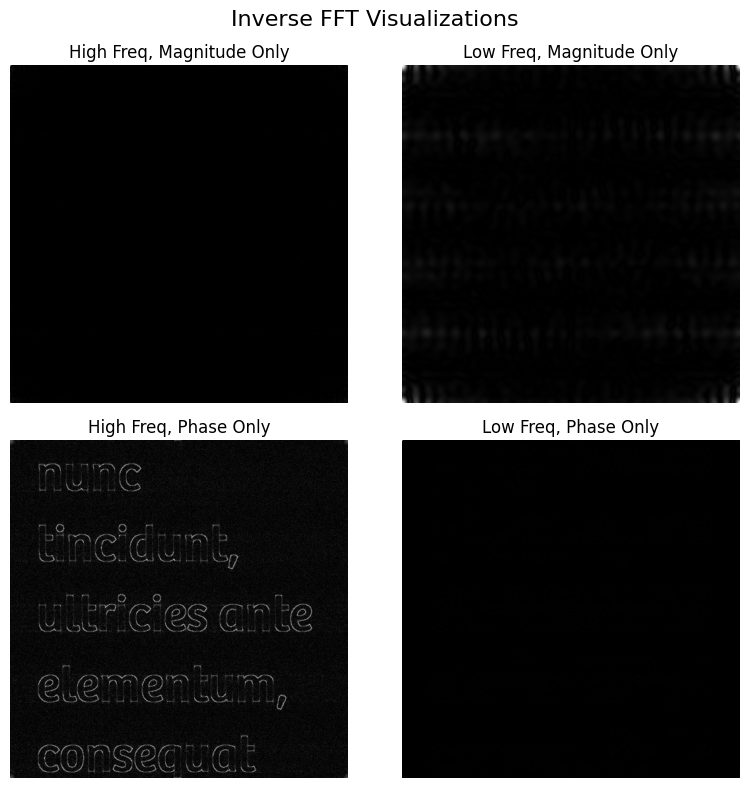

In [97]:
visualize_inverse_fft('display-76px.png')

## Two Ratios: FFT Magnitude and FFT Phase

I'll calculate two ratios (in a way such that the values are somewhat constrained to 0-1):

- the ratio of the mean of FFT magnitude to the count of non-zero binarized pixels ("FFT Magnitude Ratio")
- the ratio of the sum of the absolute value of FFT phase to the sum of binarized pixels ("FFT Phase Ratio")

Whew! Those were a mouthful. In short, I'm trying to capture the difference between FFT magnitude (and the difference between FFT phase) between images of text and do it in a way that the resulting values are somewhat between `0` and `1`.

In [137]:
magnitude_mean = np.mean(np.abs(f))
phase_sum = np.sum(np.abs(np.angle(f)))

In [138]:
magnitude_mean / np.count_nonzero(binary), phase_sum / np.sum(binary)

(0.6622262512288943, 0.0717868879051193)

## Calculating FFT Magnitude Ratio and FFT Phase Ratio for Different Images

I'll now wrap the above functionality into two functions and calculate them for a wide variety of images (of two typefaces, `display` and `serif` and 8 different font sizes).

In [2]:
def fft_magnitude_ratio(path):
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  f = np.fft.fft2(binary)

  magnitude_mean = np.mean(np.abs(f))

  total_pixels = np.count_nonzero(binary)

  ratio = magnitude_mean / total_pixels

  return ratio

In [3]:
def fft_phase_ratio(path):
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

  f = np.fft.fft2(binary)

  phase_sum = np.sum(np.abs(np.angle(f)))
  total_pixels = np.sum(binary)

  return phase_sum / total_pixels

Both the average FFT magnitude ratio (the mean of the FFT magnitude divided by the number of non-zero binarized pixels) and the average FFT phase ratio (the sum of the FFT phase divided by the sum of the binarized pixels) are higher for `serif` images than for the sans serif `display` images.

In [4]:
szs = [8, 18, 24, 36, 76, 240, 330, 420]
ts = ['display', 'serif']
res = []

for t in ts:
    for sz in szs:
        image_path = f"{t}-{sz}px.png"
        mr = fft_magnitude_ratio(image_path)
        pr = fft_phase_ratio(image_path)
        res.append([t, sz, mr, pr])

res = pd.DataFrame(res, columns=['typeface', 'font-size', 'fft-magnitude-ratio', 'fft-phase-ratio'])
res.groupby('typeface')[['fft-magnitude-ratio', 'fft-phase-ratio']].agg(['mean', 'median'])

fft-magnitude-ratio           fft-phase-ratio          
                        mean    median            mean    median
typeface                                                        
display             0.621523  0.464047        0.077332  0.042748
serif               0.801844  0.691680        0.095694  0.058342

For all font sizes except for 240px, the trend is consistent: both the magnitude and the phase ratio are higher for `serif` than `display`:

In [5]:
res.sort_values(by='font-size')

,typeface,font-size,fft-magnitude-ratio,fft-phase-ratio
0,display,8,2.028167,0.309951
8,serif,8,2.165248,0.341165
1,display,18,0.791710,0.064684
9,serif,18,1.143785,0.098539
2,display,24,0.587993,0.039971
10,serif,24,0.809721,0.056169
3,display,36,0.514101,0.040205
11,serif,36,0.721134,0.054290
4,display,76,0.413993,0.046105
12,serif,76,0.662226,0.071787


## Final Thoughts

I was hesitant to implement this algorithm because my general rule when using AI-generated code is: don't use it if I don't understand it or can't explain it. I initially started out with a much more involved algorithm generated by Claude, where it was calculating the ratio of the sum of low-frequency magnitudes to the sum of high-frequency magnitudes (after calculating 2D FFT of a binarized image). Instead of pursuing that algorithm, with the help of Claude I stripped it down to a bare minimum that I could understand and explain after putting in about an hour's worth of reading and watching different 2D FFT explanations. I still have a long ways to go before I can consider myself proficient with Fourier analysis, but this was a good start.

The two ratios that I calculated in this are relatively consistent in distinguishing `serif` typeface (high ratios) from `display` typeface (low ratios). This makes them a good candidate as a non-ML baseline.

I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).

